## Cart-pole en tabulaire

On vous propose pour finir d'utiliser votre code et de tester l'apprentissage sur le problème du cart-pole. A priori, c'est un problème où les états sont des variables continues. On vous propose ici de discrétiser les variables et d'essayer d'utiliser une des méthodes pour voir vos résultats. 

La récompense que vous obtenez est le nombre de pas de temps où le baton est resté en équilibre. Si vous utilisez colab pour coder, vous ne pourrez malheureusement pas visualiser un épisode avec la méthode render :-(

Cet environnement Cart-Pole consiste à déplacer un chariot pour faire tenir en équilibre une poutre. Plus précisément:
* Il y a deux actions : gauche et droite (représentées par 0 et 1).
* L'observation reçue (c'est à dire l'état) est un tableau numpy comprenant 4 variables: la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.
* L'épisode se termine lorsque l'angle de la poutre à la verticale dépasse 12 degrés.
* Les récompenses reçues sont égales à 1 sauf si l'angle dépasse 12 degrés.

On vous donne ci-dessous les fonctions pour réaliser la discrétisation et pour encoder l'état en un entier.


In [62]:
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np

import time

In [63]:
env_CP = gym.make("CartPole-v1")
print("Environnement avec", env_CP.action_space.n, "actions")
print("L'espace des états est lui codé avec une class", env_CP.observation_space,
      " qui représente un espace continu")
print("Les bornes inférieures des intervalles sont:", env_CP.observation_space.low)
print("Les bornes supérieures des intervalles sont:", env_CP.observation_space.high)
env_CP.reset()
nbIt=0
done=False
while not done:
    observation, reward, done, info = env_CP.step(np.random.randint(2))
    nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env_CP.close()

Environnement avec 2 actions
L'espace des états est lui codé avec une class Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)  qui représente un espace continu
Les bornes inférieures des intervalles sont: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Les bornes supérieures des intervalles sont: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 15 itérations


In [64]:
env_CP.reset() # la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.

array([ 0.04222277,  0.03696821, -0.00588483,  0.01577369])

In [65]:
env_CP.action_space # 2 actions [0, 1]

Discrete(2)

In [66]:
env_CP.step(0) # tuple((états), récompense, GAME_OVER, _)

(array([ 0.04296214, -0.15806885, -0.00556936,  0.30659409]), 1.0, False, {})

In [67]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

# Méthode aléatoire

In [68]:
# Politique aléatoire pour voir comment CARTPOLE fonctionne

def random_search(env, episodes, 
                  title='Random Strategy'):
    """ Random search strategy implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final,title)
    return final

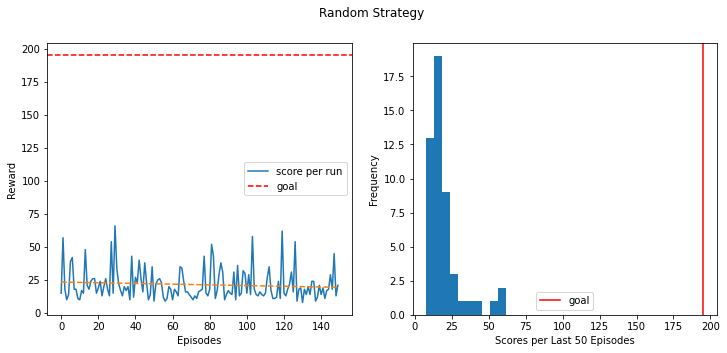

In [69]:
episodes = 150
final = random_search(env_CP, episodes)

# Méthode avec Deep Q Learning

In [70]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [71]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final

In [74]:
# Number of states
n_state = env_CP.observation_space.shape[0]
# Number of actions
n_action = env_CP.action_space.n
# Number of episodes
episodes = 160
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

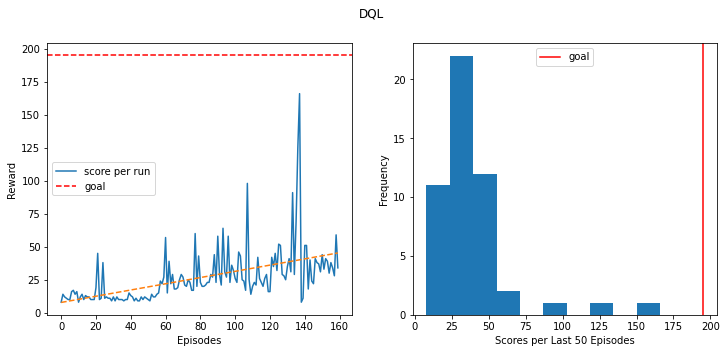

episode: 160, total reward: 34.0


In [75]:
# Get DQN results
simple_dqn = DQN(n_state, n_action, n_hidden, lr)
simple = q_learning(env_CP, simple_dqn, episodes, gamma=0.9, epsilon=0.3)